In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.random as rng
from scipy.special import expit as sigmoid

#from sklearn.neural_network import BernoulliRBM

def load_mnist_digit(digit, dataset_size):
    assert(digit >= 0 and digit < 10)
    with open("datasets/{}.npy".format(digit),'rb') as f:
        return np.load(f)[:dataset_size]
    
def flatten_dataset(images):
    smushed = images.copy()
    return smushed.reshape((smushed.shape[0], -1))

dataset_size = 200  # that's how many of EACH digit there is. Can go as high as... what, 5000?
current_digits = flatten_dataset(load_mnist_digit(0,dataset_size))
for i in range(1,2):
    current_digits = np.vstack((current_digits, flatten_dataset(load_mnist_digit(i,dataset_size))))

In [53]:
print (current_digits.shape)
num_pats = current_digits.shape[0]
num_visibles = current_digits.shape[1]

(400, 784)


## Show some examples....

(400, 784)


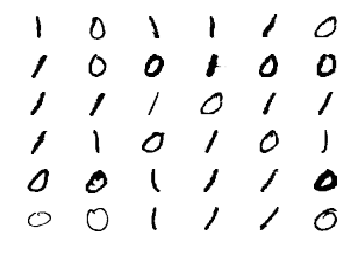

In [54]:
print(current_digits.shape)
i=0
for r in range(6):
    for c in range(6):
        plt.subplot(6,6,i+1)
        plt.imshow(current_digits[rng.randint(num_pats)].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

In [ ]:
num_hiddens = 100
h = np.zeros(shape=(num_pats, num_hiddens), dtype=int)
v = current_digits
W = rng.normal(0,1,size=(num_hiddens, num_visibles))
hidden_biases = rng.normal(size=(1, num_hiddens))
visible_biases = rng.normal(size=(1, num_visibles))
learning_rate, momentum = 0.005, 0.8
change = 0

In [ ]:
num_iterations = 250
announce_every = num_iterations / 10

for t in range(num_iterations):
    # push visible pats into hidden 
    h_prob1 = sigmoid(np.dot(v, W.T) + hidden_biases)
    h_first = 1*(h_prob1 > rng.random(size=h_prob1.shape))
    
    # push hidden pats into visible 
    v_prob1 = sigmoid(np.dot(h_first, W) + visible_biases)
    v_reconstruction = v_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))

    # push visible pats into hidden 
    h_prob1 = sigmoid(np.dot(v_reconstruction, W.T) + hidden_biases)
    h_second = 1*(h_prob1 > rng.random(size=h_prob1.shape))

    Hebb = ((np.array([h_first]*num_visibles).T)  * (np.array([v]*num_hiddens))).sum(1)
    AntiHebb = ((np.array([h_second]*num_visibles).T)  * (np.array([v_reconstruction]*num_hiddens))).sum(1)

    change = learning_rate * (Hebb - AntiHebb) + momentum * change
    W += change
    if (t % announce_every == 0): 
        print (t)

print(h.shape, v.shape)

0
25

## features

In [ ]:
i=0
for r in range(4):
    for c in range(3):
        plt.subplot(4,3,i+1)
        plt.imshow(W[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

## dreams

In [ ]:
v = v_reconstruction[0:3,:]

In [ ]:
i = 0
num_Gibbs = 1000
for t in range(num_Gibbs):
    # push visible pats into hidden 
    h_prob1 = sigmoid(np.dot(v, W.T) + hidden_biases)
    h = 1*(h_prob1 > rng.random(size=h_prob1.shape))
    
    # push hidden pats into visible 
    v_prob1 = sigmoid(np.dot(h, W) + visible_biases)
    v = v_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))
    if (t % (num_Gibbs/10) == 0): 
        plt.subplot(3,4,i+1)
        plt.imshow(v[1].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1